In [1]:
# 2D Toy training example

# dev: make sure the loss function works properly over multiple layers

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

In [5]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000

samples_xs_0 = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
# (labels are class number)
samples_labels_0 = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs_0, sep_plane)])

In [8]:
# gaussian target parameters
data_centers = -1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000

samples_xs_1 = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
# (labels are class number)
samples_labels_1 = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs_1, sep_plane)])

In [9]:
samples_xs = np.concatenate((samples_xs_0, samples_xs_1))
samples_labels = np.concatenate((samples_labels_0, samples_labels_1))

<IPython.core.display.Javascript object>


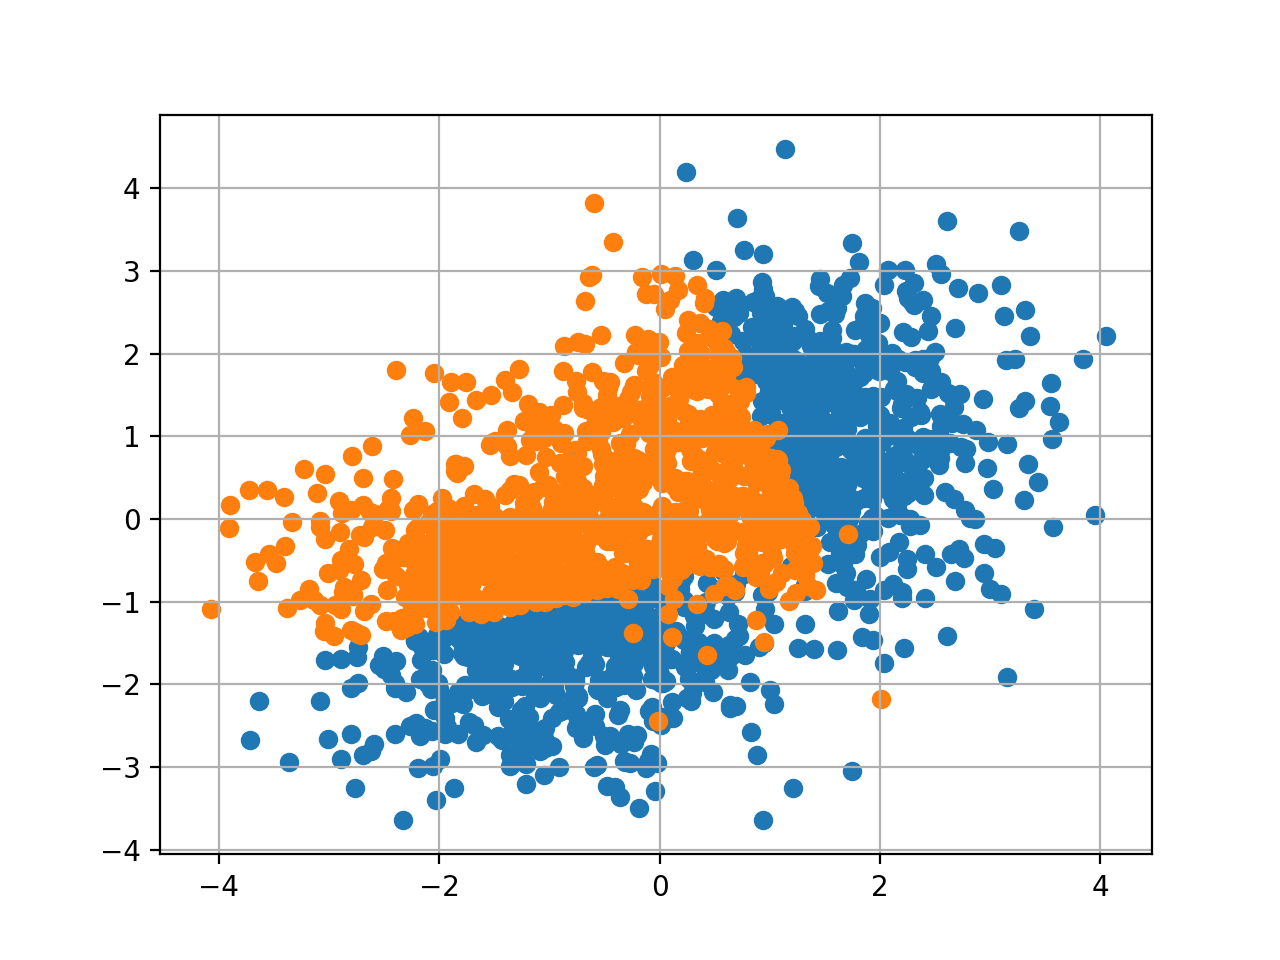

In [10]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==0]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==0]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [11]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [12]:
# Define a Finite Gaussian Neural Network
class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = th.FGN_layer(2,20)
        self.l2 = th.FGN_layer(20,2)


    def forward(self, x):
        x,l1 = self.l1(x)
        x,l2 = self.l2(x) 
        x = F.softmax(x, dim=-1)
        return x,l1+l2

In [13]:
# Initialize the network
model = FGNet().to(device)

In [14]:
# # model stats
# print(model)
# print([p.size() for p in list(model.parameters())])
# print("Training?", model.training) 

# # check sizes
# print("l1")
# print(model.l1.weights.size()) 
# print(model.l1.centers.size()) 
# print(model.l1.sigs.size())
# print(model.l1.pis.size())

# # check weights before training
# print("l1")
# print(model.state_dict())

In [15]:
# importances of the constraints
lmbda = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda)

# loss function
def loss_func(model, output, target):
    
    # split output into pred and likelihoods
    output, neg_likelihood = output
    
    # normal NLL loss
    nll_loss = 1.0*F.nll_loss(output, target.long())
    # sum of sigma squares loss
    sig_loss = 0.0
    for p in model.modules():
        if isinstance(p, th.FGN_layer):
            sig_loss += torch.abs(p.sigs).pow(2).sum()
    sig_loss = 1.0*lmbda*sig_loss
    
    nllg_loss = 1.0*lmbda*torch.sum(neg_likelihood)

    return nll_loss + sig_loss + nllg_loss

0.0005


In [16]:
# number of correct pred function
def pred_func(output, target):
    output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [17]:
# model_optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, nesterov=True)

In [18]:
epochs = 300
train_res = th.train(model, device, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 1.7780, Accuracy: 510/800 (64%)
Test set - Average loss: 0.0038, Accuracy: 593/1200 (49%)
Epoch 1 Train set - Average loss: 1.7685, Accuracy: 518/800 (65%)
Test set - Average loss: -0.0031, Accuracy: 602/1200 (50%)
Epoch 2 Train set - Average loss: 1.7609, Accuracy: 521/800 (65%)
Test set - Average loss: -0.0073, Accuracy: 608/1200 (51%)
Epoch 3 Train set - Average loss: 1.7546, Accuracy: 523/800 (65%)
Test set - Average loss: -0.0102, Accuracy: 609/1200 (51%)
Epoch 4 Train set - Average loss: 1.7469, Accuracy: 527/800 (66%)
Test set - Average loss: -0.0133, Accuracy: 609/1200 (51%)
Epoch 5 Train set - Average loss: 1.7377, Accuracy: 537/800 (67%)
Test set - Average loss: -0.0174, Accuracy: 612/1200 (51%)
Epoch 6 Train set - Average loss: 1.7304, Accuracy: 540/800 (68%)
Test set - Average loss: -0.0219, Accuracy: 619/1200 (52%)
Epoch 7 Train set - Average loss: 1.7214, Accuracy: 545/800 (68%)
Test set - Average loss: -0.0274, Accuracy: 626/1200 (52%)
E

Test set - Average loss: -0.1381, Accuracy: 710/1200 (59%)
Epoch 66 Train set - Average loss: 1.3498, Accuracy: 792/800 (99%)
Test set - Average loss: -0.1388, Accuracy: 710/1200 (59%)
Epoch 67 Train set - Average loss: 1.3483, Accuracy: 792/800 (99%)
Test set - Average loss: -0.1395, Accuracy: 710/1200 (59%)
Epoch 68 Train set - Average loss: 1.3468, Accuracy: 792/800 (99%)
Test set - Average loss: -0.1402, Accuracy: 710/1200 (59%)
Epoch 69 Train set - Average loss: 1.3453, Accuracy: 792/800 (99%)
Test set - Average loss: -0.1410, Accuracy: 710/1200 (59%)
Epoch 70 Train set - Average loss: 1.3438, Accuracy: 792/800 (99%)
Test set - Average loss: -0.1417, Accuracy: 710/1200 (59%)
Epoch 71 Train set - Average loss: 1.3424, Accuracy: 792/800 (99%)
Test set - Average loss: -0.1424, Accuracy: 710/1200 (59%)
Epoch 72 Train set - Average loss: 1.3409, Accuracy: 793/800 (99%)
Test set - Average loss: -0.1431, Accuracy: 710/1200 (59%)
Epoch 73 Train set - Average loss: 1.3394, Accuracy: 793/80

Test set - Average loss: -0.1847, Accuracy: 710/1200 (59%)
Epoch 131 Train set - Average loss: 1.2570, Accuracy: 794/800 (99%)
Test set - Average loss: -0.1854, Accuracy: 710/1200 (59%)
Epoch 132 Train set - Average loss: 1.2556, Accuracy: 794/800 (99%)
Test set - Average loss: -0.1861, Accuracy: 710/1200 (59%)
Epoch 133 Train set - Average loss: 1.2542, Accuracy: 794/800 (99%)
Test set - Average loss: -0.1869, Accuracy: 710/1200 (59%)
Epoch 134 Train set - Average loss: 1.2528, Accuracy: 794/800 (99%)
Test set - Average loss: -0.1876, Accuracy: 710/1200 (59%)
Epoch 135 Train set - Average loss: 1.2514, Accuracy: 794/800 (99%)
Test set - Average loss: -0.1883, Accuracy: 710/1200 (59%)
Epoch 136 Train set - Average loss: 1.2500, Accuracy: 794/800 (99%)
Test set - Average loss: -0.1890, Accuracy: 710/1200 (59%)
Epoch 137 Train set - Average loss: 1.2486, Accuracy: 794/800 (99%)
Test set - Average loss: -0.1897, Accuracy: 710/1200 (59%)
Epoch 138 Train set - Average loss: 1.2472, Accuracy

Test set - Average loss: -0.2330, Accuracy: 710/1200 (59%)
Epoch 196 Train set - Average loss: 1.1646, Accuracy: 796/800 (100%)
Test set - Average loss: -0.2337, Accuracy: 710/1200 (59%)
Epoch 197 Train set - Average loss: 1.1631, Accuracy: 796/800 (100%)
Test set - Average loss: -0.2345, Accuracy: 710/1200 (59%)
Epoch 198 Train set - Average loss: 1.1617, Accuracy: 797/800 (100%)
Test set - Average loss: -0.2353, Accuracy: 710/1200 (59%)
Epoch 199 Train set - Average loss: 1.1602, Accuracy: 797/800 (100%)
Test set - Average loss: -0.2361, Accuracy: 710/1200 (59%)
Epoch 200 Train set - Average loss: 1.1588, Accuracy: 798/800 (100%)
Test set - Average loss: -0.2368, Accuracy: 710/1200 (59%)
Epoch 201 Train set - Average loss: 1.1573, Accuracy: 798/800 (100%)
Test set - Average loss: -0.2376, Accuracy: 710/1200 (59%)
Epoch 202 Train set - Average loss: 1.1559, Accuracy: 798/800 (100%)
Test set - Average loss: -0.2384, Accuracy: 710/1200 (59%)
Epoch 203 Train set - Average loss: 1.1544, A

Test set - Average loss: -0.2829, Accuracy: 709/1200 (59%)
Epoch 261 Train set - Average loss: 1.0662, Accuracy: 799/800 (100%)
Test set - Average loss: -0.2836, Accuracy: 709/1200 (59%)
Epoch 262 Train set - Average loss: 1.0646, Accuracy: 799/800 (100%)
Test set - Average loss: -0.2844, Accuracy: 709/1200 (59%)
Epoch 263 Train set - Average loss: 1.0629, Accuracy: 799/800 (100%)
Test set - Average loss: -0.2851, Accuracy: 709/1200 (59%)
Epoch 264 Train set - Average loss: 1.0613, Accuracy: 799/800 (100%)
Test set - Average loss: -0.2859, Accuracy: 709/1200 (59%)
Epoch 265 Train set - Average loss: 1.0597, Accuracy: 799/800 (100%)
Test set - Average loss: -0.2866, Accuracy: 709/1200 (59%)
Epoch 266 Train set - Average loss: 1.0581, Accuracy: 799/800 (100%)
Test set - Average loss: -0.2873, Accuracy: 709/1200 (59%)
Epoch 267 Train set - Average loss: 1.0564, Accuracy: 799/800 (100%)
Test set - Average loss: -0.2881, Accuracy: 709/1200 (59%)
Epoch 268 Train set - Average loss: 1.0548, A

In [19]:
# test model, should be same or close to last line in above cell
th.test(model, device, my_test_dataloader, loss_func, verbose=True, pred_func=pred_func)

Test set - Average loss: -0.3109, Accuracy: 709/1200 (59%)


{'test_accuracy': 59.083333333333336, 'test_loss': -0.31088555762544273}

In [20]:
# # print model state_dict post training
# model.state_dict()

<IPython.core.display.Javascript object>


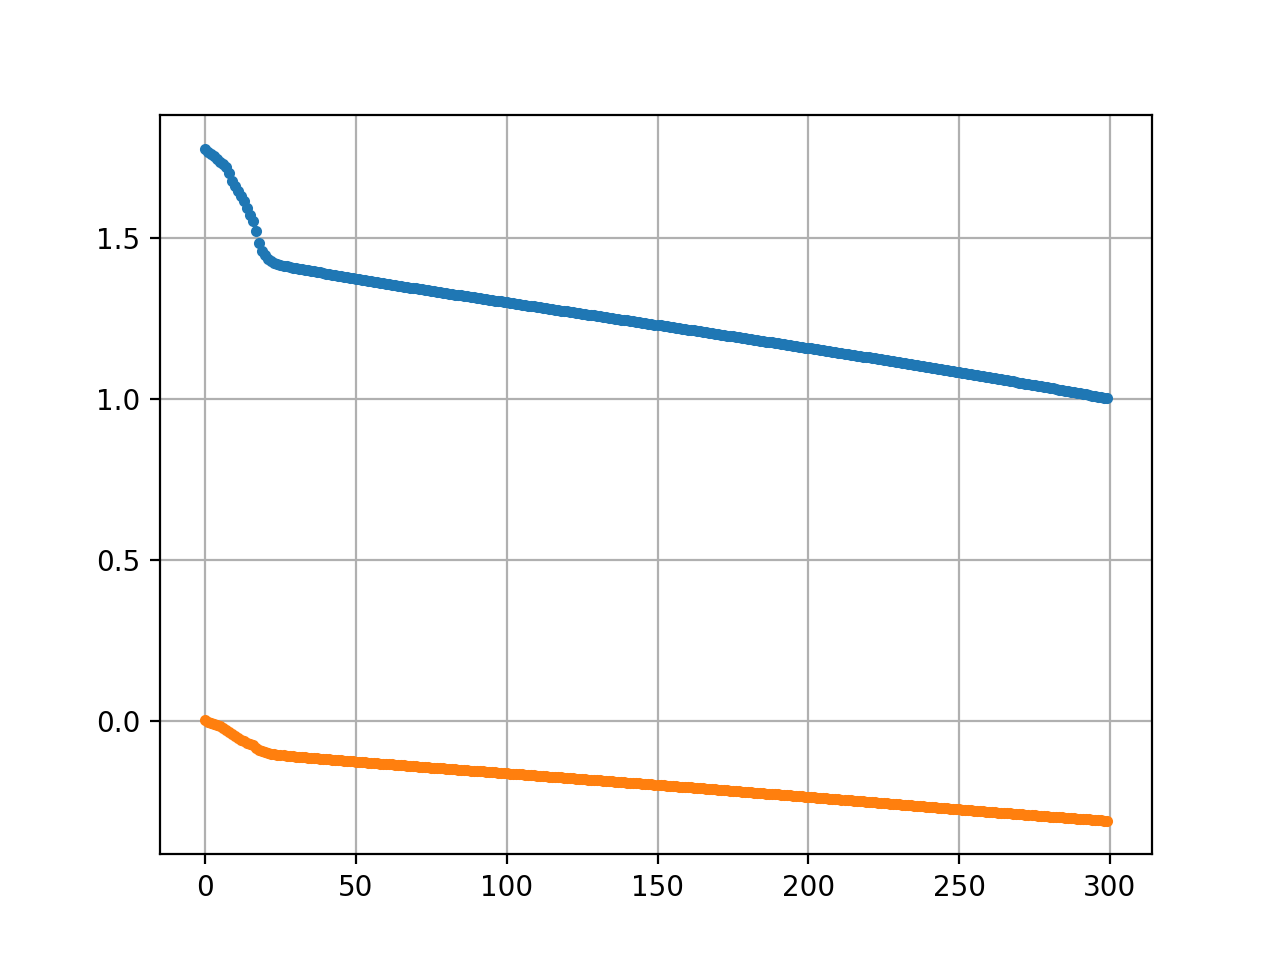

<IPython.core.display.Javascript object>


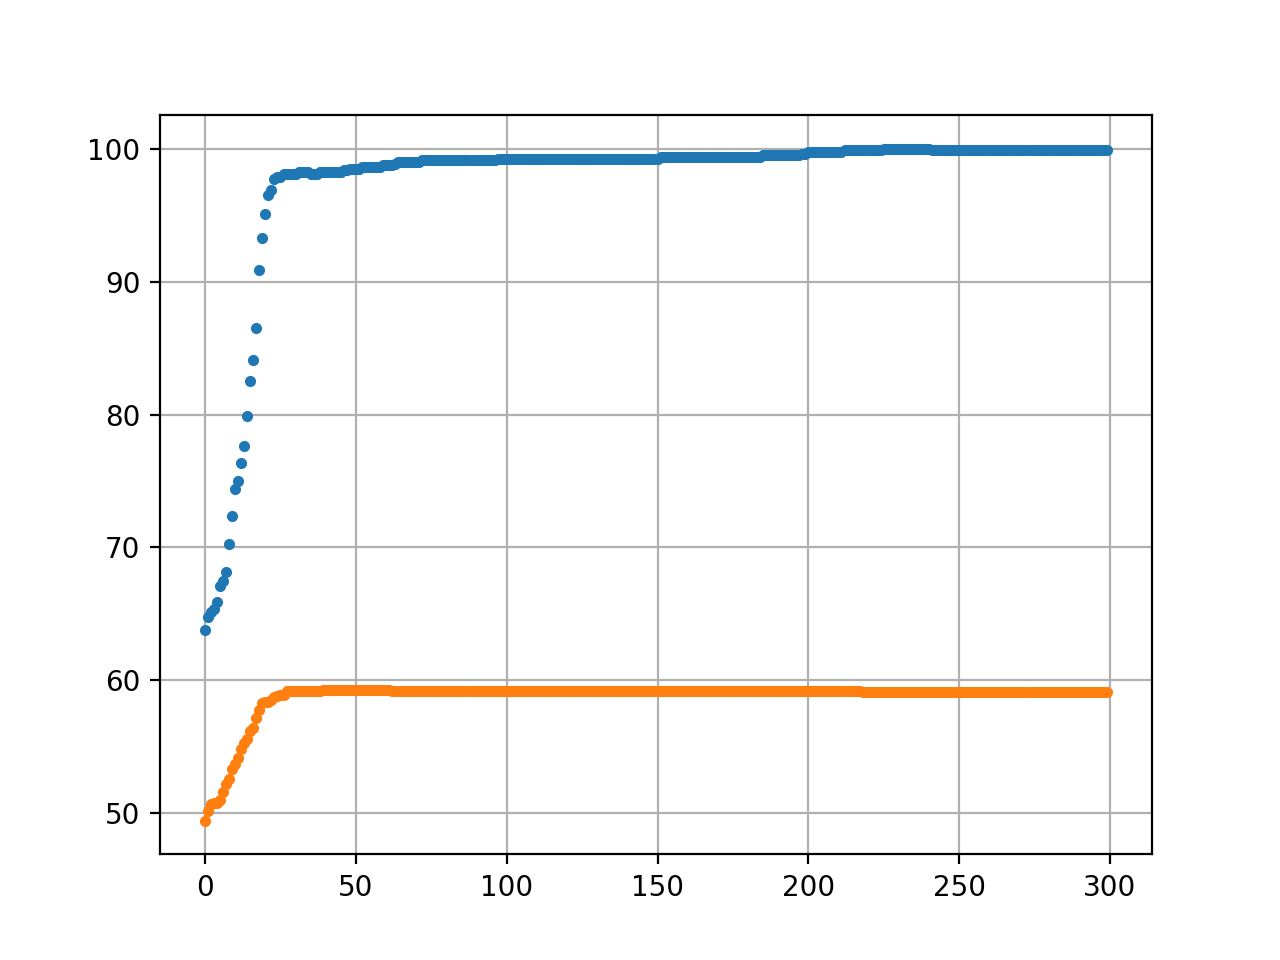

In [21]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


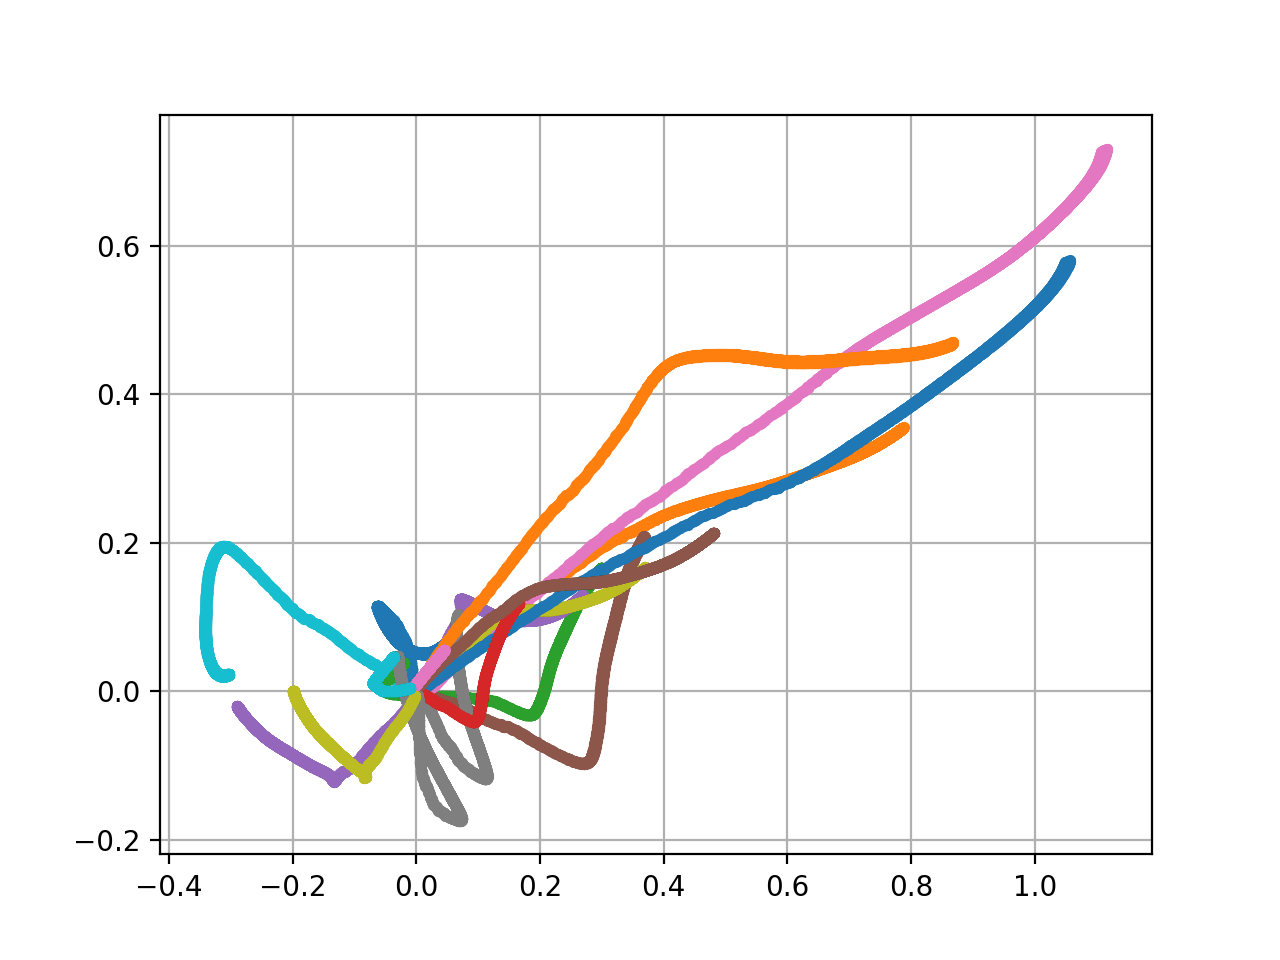

In [22]:
# compare centers
for i in range(20):
    x, y = zip(*train_res['histories']['l1.centers'][:,i,:])
    plt.plot(x,y, marker='.', linestyle='-')
# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


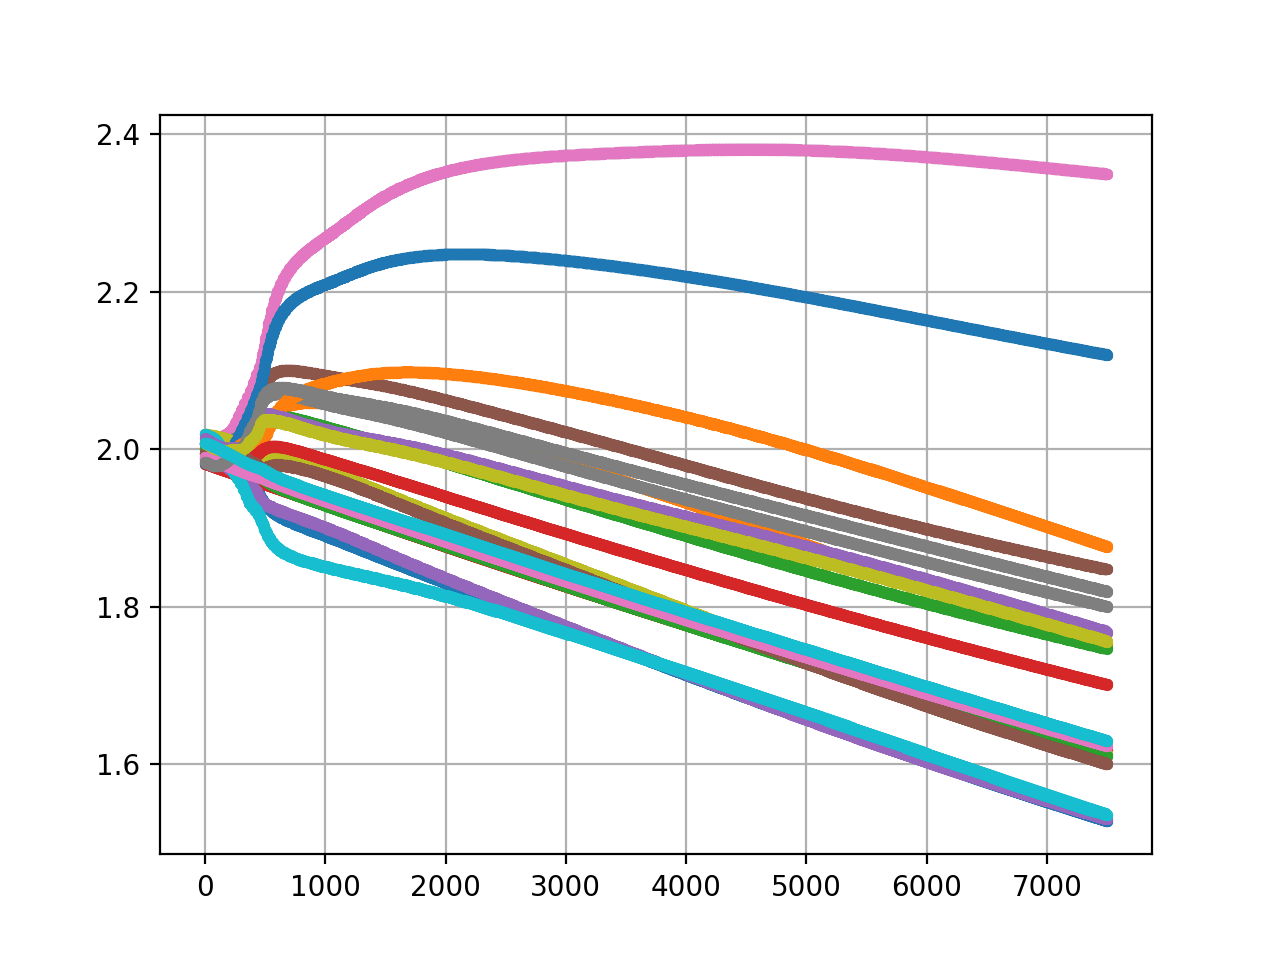

<IPython.core.display.Javascript object>


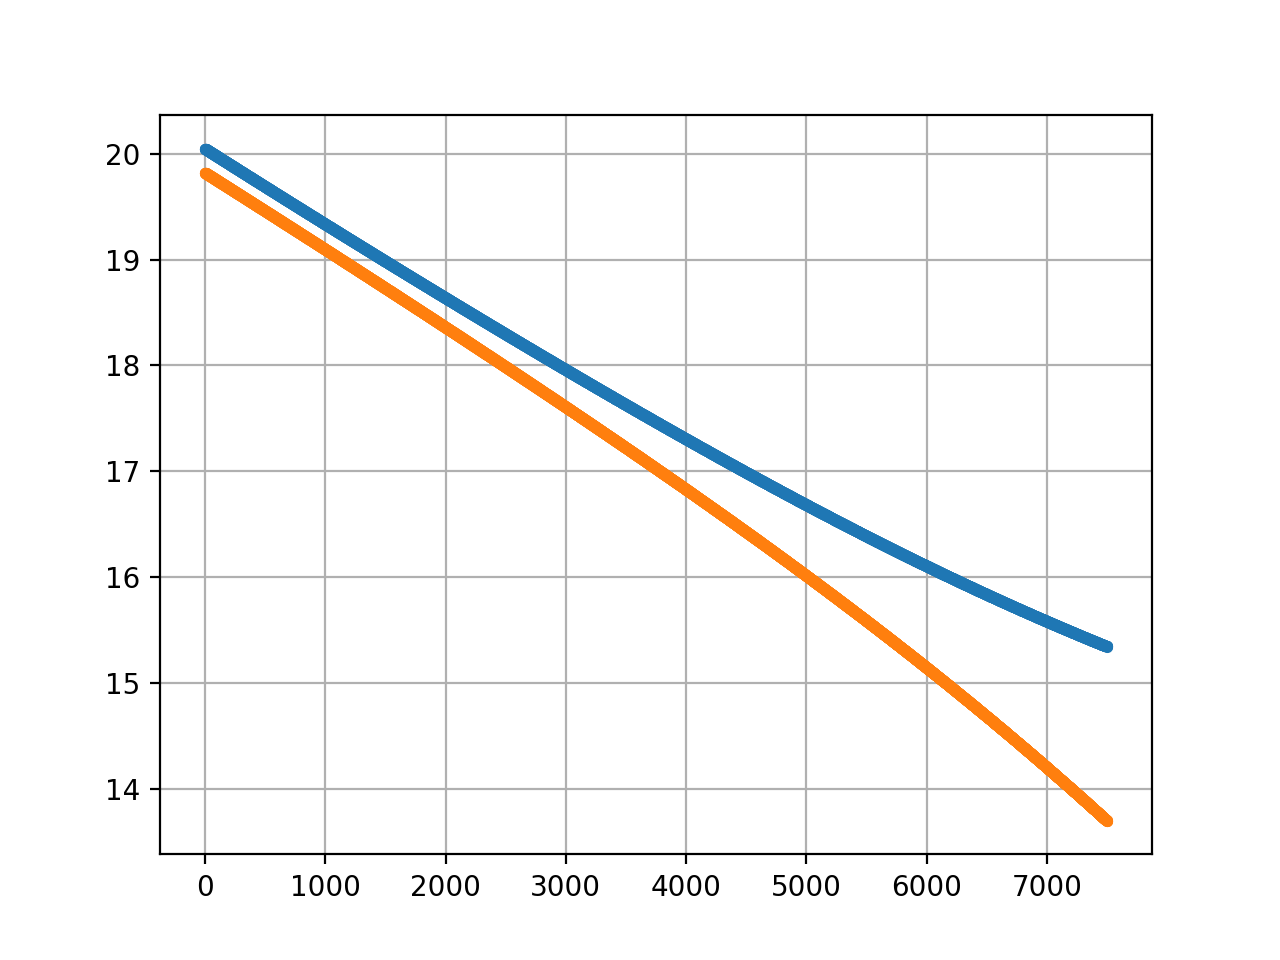

In [23]:
# check that sigma has shrunk
# plot sigma history
for k in train_res['histories'].keys():
    if 'sigs' in k:
        for i in range(len(train_res['histories'][k][0])):
            plt.plot(train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()

In [24]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

<IPython.core.display.Javascript object>


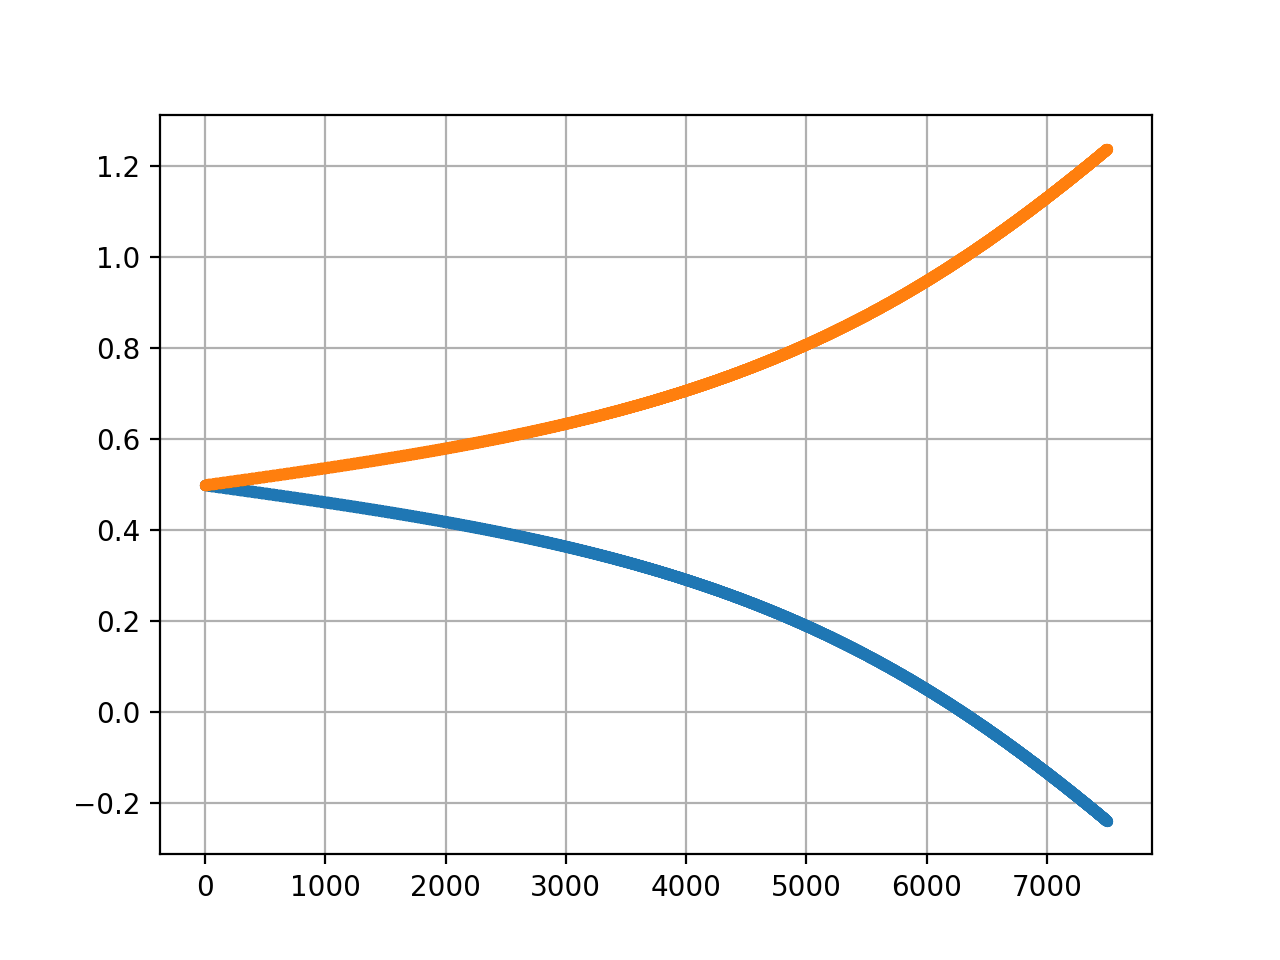

<IPython.core.display.Javascript object>


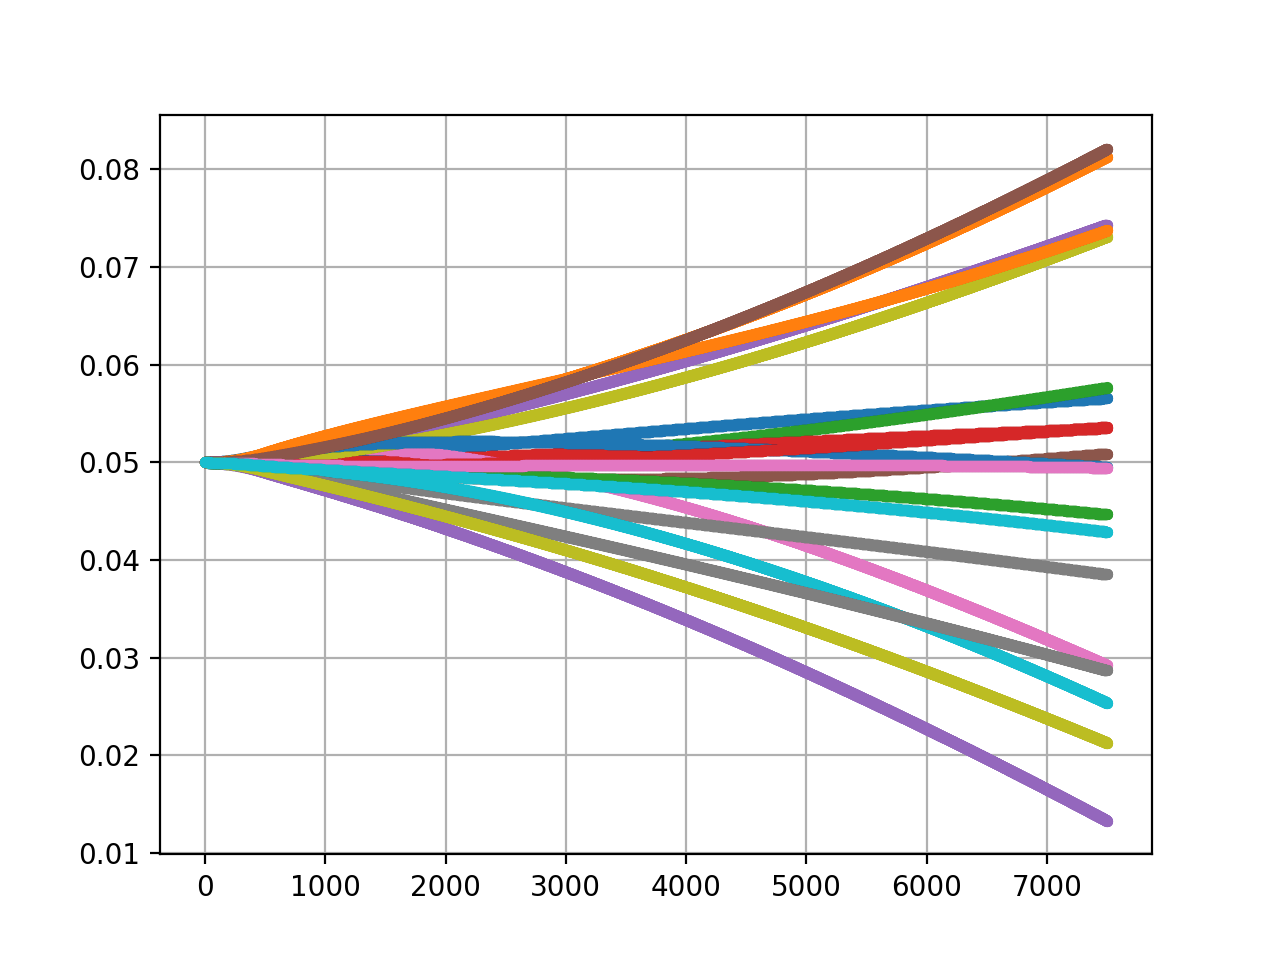

In [28]:
# plot softmax(PIs) history

# unormalized
for k in train_res['histories'].keys():
    if 'pis' in k:
        for i in range(len(train_res['histories'][k][0])):
            plt.plot(train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()

# #normalized 
# normalized_PIs = np.array([softmax(x) for x in train_res['histories']['l1.pis']])
# plt.plot(normalized_PIs[:,0], marker='.', linestyle=' ')
# plt.plot(normalized_PIs[:,1], marker='.', linestyle=' ')

# plt.grid()
# plt.show()